In [1]:

import os
import sys
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt, ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pysar.simulation.plot import *
from pysar.objects import timeseries, ifgramStack, sensor, gps
from pysar.utils import readfile, writefile, ptime, plot as pp, utils as ut, network as pnet
from pysar.utils.insar_vs_gps import insar_vs_gps
from pysar import view, ifgram_inversion as ifginv

work_dir = os.path.expanduser('~/development/python/2018_ComputGeosci_PySAR/network_redundancy')
os.chdir(work_dir)
print('Go to directory: '+work_dir)

# GPS
gps_dir = os.path.expanduser('~/insarlab/Galapagos/GPS')
site_names = ['GV{:02d}'.format(i) for i in [1] + np.arange(3,11).tolist()]
ref_site = 'GV01'

# InSAR
proj_dir = os.path.expanduser('~/insarlab/Galapagos/GalapagosSenDT128_30CONN/PYSAR')
ifgram_file = os.path.join(proj_dir, 'INPUTS/ifgramStack.h5')
geom_file   = os.path.join(proj_dir, 'INPUTS/geometryRadar.h5')
trop_file   = os.path.join(proj_dir, 'INPUTS/ECMWF.h5')

out_file = os.path.join(work_dir, 'data_{}.pickle'.format(ref_site))

Go to directory: /Users/yunjunz/development/python/2018_ComputGeosci_PySAR/network_redundancy


In [2]:
## Read / Generate data
num_conn_max = 20
if not os.path.isfile(out_file):
    dsDict = {}
    for i in range(1,num_conn_max+1):
        conn = '{:02d}CONN'.format(i)
        print(conn)
        ts_file       = os.path.join(proj_dir, conn, 'timeseries.h5')
        temp_coh_file = os.path.join(proj_dir, conn, 'temporalCoherence.h5')
        obj = insar_vs_gps(ts_file, geom_file, temp_coh_file, site_names, gps_dir, ref_site)
        obj.open()
        dsDict[conn] = dict(obj.ds)
    
    with open(out_file, 'wb') as f:
        pickle.dump(dsDict, f)
    print('Saved to pickle file {}.'.format(out_file))
else:
    with open(out_file, 'rb') as f:
        dsDict = pickle.load(f)

# info
conn_list = sorted(list(dsDict.keys()))
num_conn = len(conn_list)
site_names = sorted(list(dsDict[conn_list[2]].keys()))
x = np.arange(1, num_conn+1)

def read_data(site2read, min_tcoh=0):
    # dsDict --> rmse
    rmse = np.zeros((num_conn, len(site2read)))
    tcoh = np.zeros((num_conn, len(site2read)))
    for i in range(num_conn):
        ds = dsDict[conn_list[i]]
        for j in range(len(site2read)):
            site = ds[site2read[j]]
            rmse[i, j] = site['dis_rmse']
            tcoh[i, j] = site['temp_coh']
    rmse *= 100.  #[cm]
    rmse[tcoh < min_tcoh] = np.nan
    return rmse, tcoh
    
print('Done.')

Done.


In [3]:
# Get number of reliable pixels for each connection
num_pixel = np.zeros(num_conn)
for i in range(num_conn):
    conn = '{:02d}CONN'.format(i+1)
    temp_coh = readfile.read(os.path.join(proj_dir, conn, 'temporalCoherence.h5'))[0]
    num_pixel[i] = np.sum(temp_coh >= 0.7)
print('Done.')

Done.


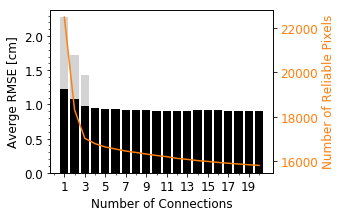

In [13]:
## Plot Figure 12

sites1 = [i for i in site_names if i not in [ref_site]]
sites2 = [i for i in site_names if i not in [ref_site, 'GV10']]
rmse1 = read_data(sites1, min_tcoh=0.7)[0]
rmse2 = read_data(sites2, min_tcoh=0.7)[0]

# plot
color = pp.mplColors[0]
color = 'k'
fig, ax = plt.subplots(figsize=[4, 3])
ax.bar(x, np.nanmean(rmse1, axis=1), color='lightgray')
ax.bar(x, np.nanmean(rmse2, axis=1), color=color)
# axis format
ax.set_xticks(np.arange(1, num_conn+1, 2));
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', direction='out', labelsize=font_size)
ax.tick_params(axis='y', labelcolor=color)
ax.set_xlabel('Number of Connections', fontsize=font_size)
ax.set_ylabel('Averge RMSE [cm]', fontsize=font_size, color=color)


# ax2
color = pp.mplColors[1]
#color = 'crimson'
ax2 = ax.twinx()
ax2.set_ylabel('Number of Reliable Pixels', fontsize=font_size, color=color)
ax2.plot(x, num_pixel, color=color)
ax2.tick_params(axis='y', labelsize=font_size, labelcolor=color)

plt.savefig('avg_rmse_numPixel.png', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

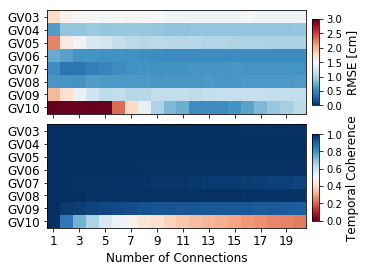

In [53]:
## Plot Supp Figures
site2plot = [i for i in site_names if i not in [ref_site]]
rmse, tcoh = read_data(site2plot)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[5, 4], sharex=True)
im1 = axs[0].imshow(rmse.T, vmin=0, vmax=3, cmap='RdBu_r')
im2 = axs[1].imshow(tcoh.T, vmin=0, vmax=1, cmap='RdBu')

fig.subplots_adjust(hspace=0.1)
cax1 = fig.add_axes([0.89, 0.55, 0.02, 0.3])
cbar1 = plt.colorbar(im1, cax=cax1)
cbar1.set_label('RMSE [cm]', fontsize=font_size)
cax2 = fig.add_axes([0.89, 0.15, 0.02, 0.3])
cbar2 = plt.colorbar(im2, cax=cax2)
cbar2.set_label('Temporal Coherence', fontsize=font_size)

for ax in axs:
    ax.set_yticks(np.arange(0, len(site2plot)));
    ax.set_yticklabels(site2plot, fontsize=font_size)
    ax.set_xticks(np.arange(0, num_conn, 2));
    ax.set_xticklabels(np.arange(1, num_conn+1, 2), fontsize=font_size);
axs[1].set_xlabel('Number of Connections', fontsize=font_size)

plt.savefig('rmse_tcoh.png', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

view.py /Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128_30CONN/PYSAR/20CONN/temporalCoherence.h5 --notitle --dpi 600 --fontsize 12 -c RdBu --ref-size 3 


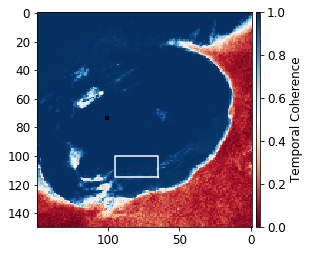

In [64]:
## Plot Supp Figure - Temporal Coherence with 20 conn
tcoh_file = os.path.join(proj_dir, '20CONN/temporalCoherence.h5')
tmpl_file = os.path.join(proj_dir, 'template.txt')
aoi = readfile.read_template(tmpl_file)['pysar.network.aoiYX']
aoiy, aoix = aoi.split(',')
y0, y1 = [int(i) for i in aoiy.split(':')]
x0, x1 = [int(i) for i in aoix.split(':')]

fig, ax = plt.subplots(figsize=[4, 4])
# call view.py to plot
cmd = 'view.py {} --notitle --dpi 600 --fontsize 12 -c RdBu --ref-size 3 '.format(tcoh_file)
print(cmd)
d_v, atr, inps = view.prep_slice(cmd, print_msg=False)
inps.cbar_label = "Temporal Coherence"
ax, inps, im, cbar = view.plot_slice(ax, d_v, atr, inps, print_msg=False)

# plot AOI
xx = [x0, x1, x1, x0, x0]
yy = [y1, y1, y0, y0, y1]
ax.plot(xx, yy, color='w')
plt.savefig('tcoh_20conn.png', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()